<a href="https://colab.research.google.com/github/alish21-max/-Getting-and-Cleaning-Data-Course-Project/blob/main/hlrcc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#load dataset

In [ ]:
import pandas as pd
import numpy as np
data = pd.read_csv('combined.csv')
X = data.drop(columns=["malignant"])
y = data["malignant"]
X.fillna(X.mean(), inplace=True)

#Standardizing features for better performance

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
import xgboost as xgb

# Load dataset

In [ ]:
data = pd.read_csv("combined.csv")
X = data.drop(columns=["malignant"])
y = data["malignant"]

# Handle missing values and scale features

In [ ]:
X.fillna(X.mean(), inplace=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split your data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

# Perform Lasso regression to find important features

In [ ]:
import numpy as np

# Evaluate 50 alphas between 10^-4 and 10^1
alphas = np.logspace(-2, 0, 130)  # 50 alphas from 0.0001 to 10
param_grid = {'alpha': alphas}

grid_search = GridSearchCV(lasso, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Best alpha
best_alpha = grid_search.best_params_['alpha']
print(f"Best Alpha: {best_alpha}")

Best Alpha: 0.1739042026608188


# Best alpha

In [ ]:
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")


Best alpha: 0.1739042026608188


# Train Lasso with the best alpha

In [ ]:
lasso = Lasso(alpha=best_alpha, max_iter=10000)
lasso.fit(X_train, y_train)

Lasso(alpha=0.1739042026608188, max_iter=10000)

# Extract important features

In [ ]:
feature_coefficients = lasso.coef_
selected_features = [i for i, coef in enumerate(feature_coefficients) if coef != 0]

# Subset the data with selected features

In [ ]:
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]

#Adjust the Code for Your Dataset

In [ ]:
feature_names = X.columns
selected_feature_names = feature_names[lasso.coef_ != 0]
print(f"Selected features: {selected_feature_names}")

Selected features: Index(['a_wavelet_LLH_glrlm_RunVariance',
       'p_logarithm_gldm_DependenceNonUniformityNormalized',
       'p_logarithm_gldm_LargeDependenceEmphasis',
       'p_wavelet_HLL_glrlm_LongRunEmphasis'],
      dtype='object')


#Export Results

In [ ]:
# Extract selected feature indices from Lasso
selected_feature_indices = [i for i, coef in enumerate(feature_coefficients) if coef != 0]

# Filter the original dataset
selected_variables = X.iloc[:, selected_feature_indices]

# Add the target column back for reference
selected_variables_with_target = pd.concat([selected_variables, y], axis=1)

# Save the dataset to a CSV file
selected_variables_with_target.to_csv("selected_variables.csv", index=False)

print(f"Selected variables and target saved to 'selected_variables.csv'.")

Selected variables and target saved to 'selected_variables.csv'.


#Extract Coefficients and Lambda

In [ ]:
# Get the best alpha (lambda) value
best_lambda = grid_search.best_params_['alpha']
print(f"Best Lambda (Alpha): {best_lambda}")

# Get the coefficients of the Lasso model
lasso_coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lasso.coef_
})

# Filter non-zero coefficients
non_zero_coefficients = lasso_coefficients[lasso_coefficients["Coefficient"] != 0]

print(f"Number of Selected Features: {len(non_zero_coefficients)}")
print(non_zero_coefficients)

Best Lambda (Alpha): 0.1739042026608188
Number of Selected Features: 4
                                                Feature  Coefficient
1108                    a_wavelet_LLH_glrlm_RunVariance     0.018702
5413  p_logarithm_gldm_DependenceNonUniformityNormal...     0.042451
5418           p_logarithm_gldm_LargeDependenceEmphasis     0.003825
5894                p_wavelet_HLL_glrlm_LongRunEmphasis     0.045590


#Visualize Coefficients

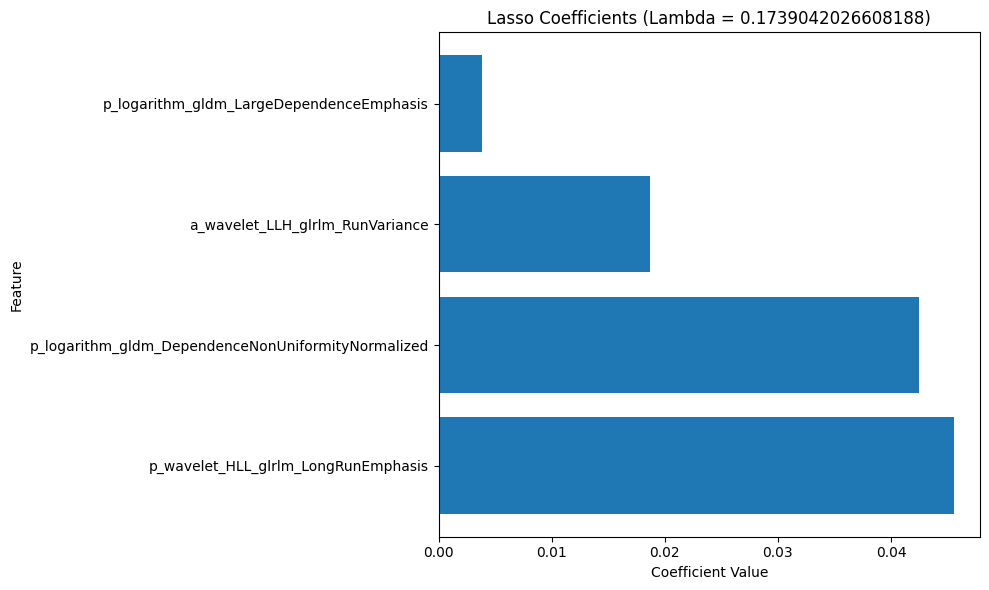

In [ ]:
import matplotlib.pyplot as plt

# Sort coefficients by magnitude
non_zero_coefficients = non_zero_coefficients.sort_values(by="Coefficient", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(non_zero_coefficients["Feature"], non_zero_coefficients["Coefficient"])
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title(f"Lasso Coefficients (Lambda = {best_lambda})")
plt.tight_layout()
plt.show()

#Visualize the Effect of Lambda

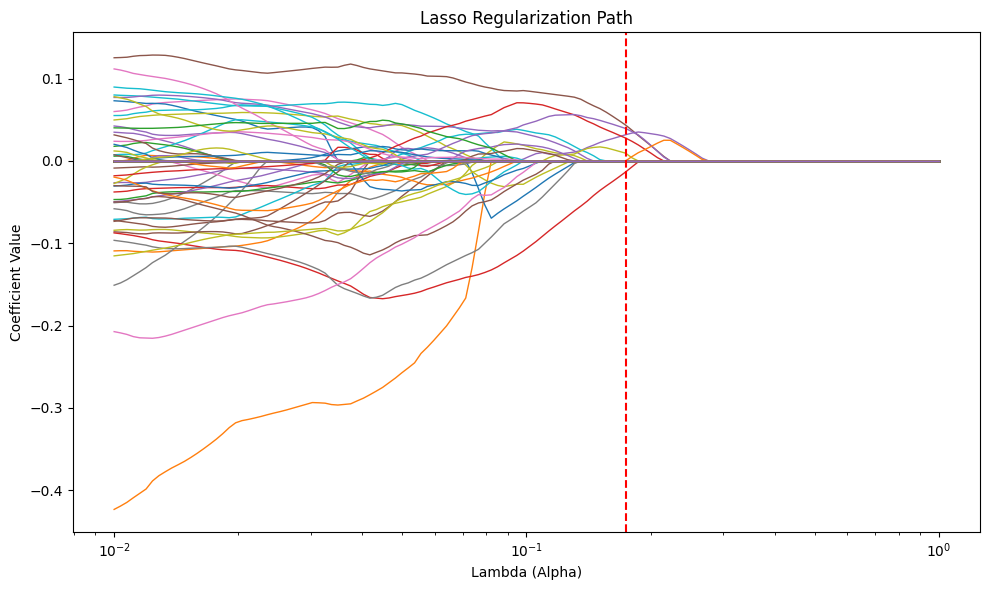

In [ ]:
from sklearn.linear_model import lasso_path

# Compute the Lasso path for a range of alphas
alphas, coefs, _ = lasso_path(X_train, y_train, alphas=alphas)

# Plot regularization path
plt.figure(figsize=(10, 6))
for i in range(coefs.shape[0]):
    plt.plot(alphas, coefs[i, :], label=f"Feature {i}" if i < 10 else "", lw=1)

plt.xscale("log")
plt.xlabel("Lambda (Alpha)")
plt.ylabel("Coefficient Value")
plt.title("Lasso Regularization Path")
plt.axvline(x=best_lambda, color="red", linestyle="--", label="Best Lambda")
plt.tight_layout()
plt.show()


#Compute AUC for Different Lambda Values

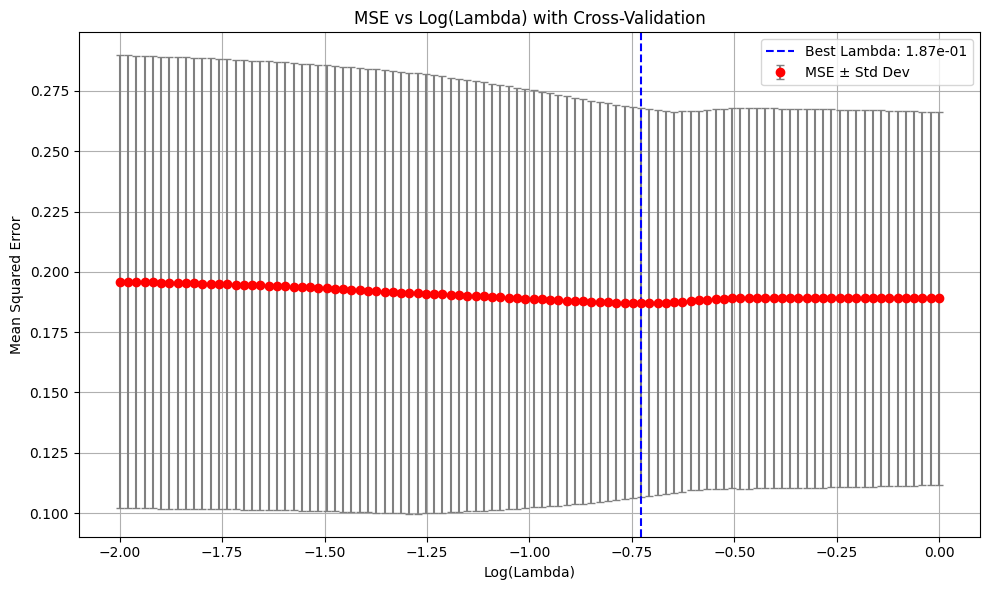

Best Lambda: 0.1873817422860385
Lowest Mean MSE: 0.18710798796033556


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Assuming your split data is already defined:
# X_train, y_train

# Convert to NumPy arrays
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)

# Define a range of lambda (alpha) values
lambdas = np.logspace(-2, 0, 100)  # Adjust range as needed for your dataset

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mean_mse = []  # Store mean MSE for each lambda
std_mse = []   # Store standard deviation of MSE for each lambda

# Iterate over lambda values
for lmbda in lambdas:
    mse_values = []

    # Perform cross-validation
    for train_idx, val_idx in kf.split(X_train_np):
        # Split data into training and validation sets
        X_train_cv, X_val_cv = X_train_np[train_idx], X_train_np[val_idx]
        y_train_cv, y_val_cv = y_train_np[train_idx], y_train_np[val_idx]

        # Train Lasso model with the current lambda
        lasso = Lasso(alpha=lmbda, max_iter=10000)
        lasso.fit(X_train_cv, y_train_cv)

        # Predict on validation set
        y_val_pred = lasso.predict(X_val_cv)

        # Calculate MSE for the current fold
        mse = mean_squared_error(y_val_cv, y_val_pred)
        mse_values.append(mse)

    # Compute mean and std of MSE for the current lambda
    mean_mse.append(np.mean(mse_values))
    std_mse.append(np.std(mse_values))

# Find the best lambda (lowest mean MSE)
best_lambda_idx = np.argmin(mean_mse)
best_lambda = lambdas[best_lambda_idx]

# Plot MSE vs log(Lambda) with red dots
plt.figure(figsize=(10, 6))
plt.errorbar(
    np.log10(lambdas),
    mean_mse,
    yerr=std_mse,
    fmt='ro',  # 'r' for red, 'o' for dot marker
    ecolor='gray',
    capsize=3,
    label="MSE ± Std Dev"
)
plt.axvline(x=np.log10(best_lambda), color='blue', linestyle='--', label=f"Best Lambda: {best_lambda:.2e}")
plt.xlabel("Log(Lambda)")
plt.ylabel("Mean Squared Error")
plt.title("MSE vs Log(Lambda) with Cross-Validation")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Print the best lambda and corresponding MSE
print(f"Best Lambda: {best_lambda}")
print(f"Lowest Mean MSE: {mean_mse[best_lambda_idx]}")


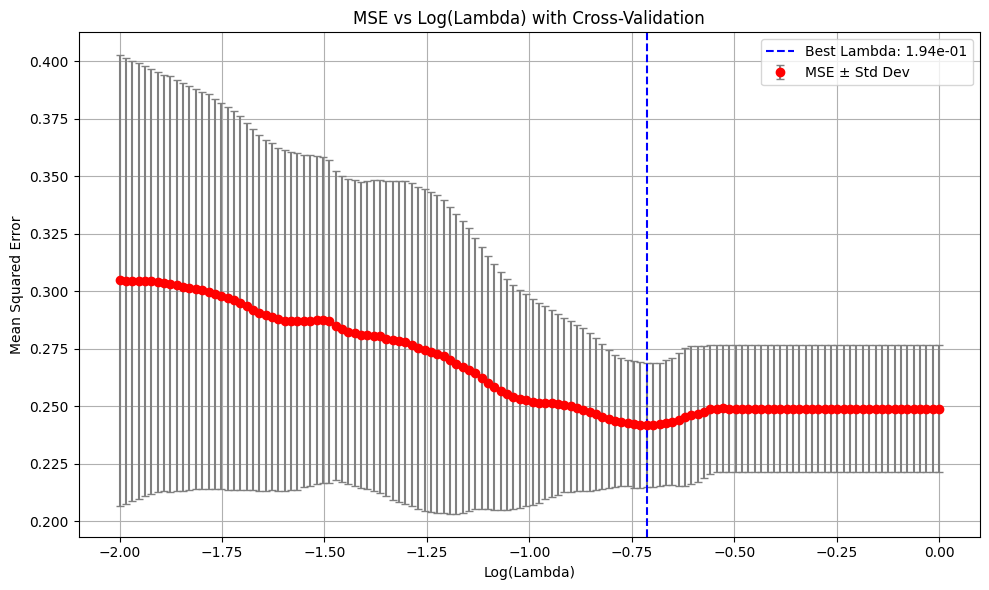

Best Lambda: 0.19356271514803752
Lowest Mean MSE: 0.24166667594194086


In [ ]:
# Plot MSE vs log(Lambda) with red dots
plt.figure(figsize=(10, 6))
plt.errorbar(
    np.log10(lambdas),
    mean_mse,
    yerr=std_mse,
    fmt='ro',  # 'r' for red, 'o' for dot marker
    ecolor='gray',
    capsize=3,
    label="MSE ± Std Dev"
)
plt.axvline(x=np.log10(best_lambda), color='blue', linestyle='--', label=f"Best Lambda: {best_lambda:.2e}")
plt.xlabel("Log(Lambda)")
plt.ylabel("Mean Squared Error")
plt.title("MSE vs Log(Lambda) with Cross-Validation")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Print the best lambda and corresponding MSE
print(f"Best Lambda: {best_lambda}")
print(f"Lowest Mean MSE: {mean_mse[best_lambda_idx]}")


#model AUC


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Load the dataset with selected variables
selected_data = pd.read_csv("selected_variables.csv")  # Replace with your file path

# Split into features (X) and target (y)
X = selected_data.drop(columns=["malignant"])  # Replace "target" with your target column name
y = selected_data["malignant"]  # Replace "target" with your target column name

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


#train

In [ ]:
# Train a Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

#auc

In [ ]:
# Predict probabilities
y_train_pred = model.predict_proba(X_train)[:, 1]  # Probabilities for the positive class
y_test_pred = model.predict_proba(X_test)[:, 1]    # Probabilities for the positive class

# Calculate AUC
train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

print(f"Train AUC: {train_auc:.3f}")
print(f"Test AUC: {test_auc:.3f}")


Train AUC: 0.825
Test AUC: 0.829


#XGboosting

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb

# Load the dataset with selected variables
selected_data = pd.read_csv("selected_variables.csv")  # Replace with your file path

# Split into features (X) and target (y)
X = selected_data.drop(columns=["malignant"])  # Replace "target" with your target column name
y = selected_data["malignant"]  # Replace "target" with your target column name

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


#train

In [ ]:
# Convert data to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
params = {
    "objective": "binary:logistic",  # Binary classification
    "eval_metric": "auc",           # Evaluate using AUC
  'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.9874215678786049, 'colsample_bytree': 0.607354925461094, 'eta': 0.03201940266815745, 'lambda': 1.338219315029646, 'alpha': 0.7031148353207308}

# Train the XGBoost model
num_round = 100
evals = [(dtrain, "train"), (dtest, "test")]
model = xgb.train(params, dtrain, num_round, evals, early_stopping_rounds=10, verbose_eval=10)


[0]	train-auc:0.88200	test-auc:0.84286
[10]	train-auc:0.90747	test-auc:0.85714


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


#hyperparatmeter tuning

In [ ]:
import optuna
import xgboost as xgb

def objective(trial):
    # Suggest hyperparameters
    param = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "eta": trial.suggest_float("eta", 0.01, 0.6),
        "lambda": trial.suggest_float("lambda", 1, 10),
        "alpha": trial.suggest_float("alpha", 0, 1),
        "seed": 42
    }
    # Train XGBoost model
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(param, dtrain, num_boost_round=100, evals=[(dval, "val")], early_stopping_rounds=10, verbose_eval=False)

    # Train XGBoost model
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(param, dtrain, num_boost_round=100, evals=[(dval, "val")], early_stopping_rounds=10, verbose_eval=False)

    # Predict and calculate AUC
    y_val_pred = model.predict(dval)
    auc = roc_auc_score(y_test, y_val_pred)
    return auc
# Run optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150)

# Best hyperparameters
print("Best Parameters:", study.best_params)



[I 2024-11-26 21:27:04,353] A new study created in memory with name: no-name-274b149f-fbd2-420f-ad57-97f126ac4d0f
[I 2024-11-26 21:27:04,386] Trial 0 finished with value: 0.8357142857142857 and parameters: {'max_depth': 2, 'min_child_weight': 2, 'subsample': 0.7449082709423589, 'colsample_bytree': 0.6501939856069843, 'eta': 0.38478960686707303, 'lambda': 9.065451608439032, 'alpha': 0.8575249237775974}. Best is trial 0 with value: 0.8357142857142857.
[I 2024-11-26 21:27:04,416] Trial 1 finished with value: 0.5 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.8173351978177019, 'colsample_bytree': 0.6352538309942048, 'eta': 0.3831301696649754, 'lambda': 1.9443810301304136, 'alpha': 0.03501939065746973}. Best is trial 0 with value: 0.8357142857142857.
[I 2024-11-26 21:27:04,452] Trial 2 finished with value: 0.85 and parameters: {'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.614121316124028, 'colsample_bytree': 0.5683085288454127, 'eta': 0.15205319524013672, 

Best Parameters: {'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.9874215678786049, 'colsample_bytree': 0.607354925461094, 'eta': 0.03201940266815745, 'lambda': 1.338219315029646, 'alpha': 0.7031148353207308}


#evaluate

In [ ]:
# Predict probabilities
y_train_pred = model.predict(dtrain)
y_test_pred = model.predict(dtest)

# Calculate AUC
train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

print(f"Train AUC: {train_auc:.3f}")
print(f"Test AUC: {test_auc:.3f}")


Train AUC: 0.907
Test AUC: 0.857


#aggregated Confusin matrix

Confusion Matrix:
[[37  4]
 [ 8 18]]


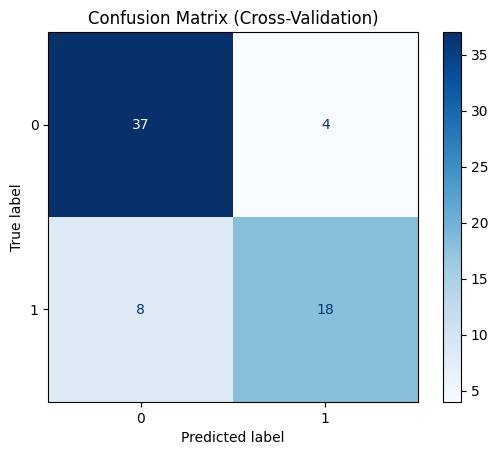

Overall AUC: 0.797


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming X and y are defined as your dataset and target
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Arrays to store true labels and predictions
y_true_all = []
y_pred_all = []

# Perform cross-validation
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train XGBoost model
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.9874215678786049, 'colsample_bytree': 0.607354925461094, 'eta': 0.03201940266815745, 'lambda': 1.338219315029646, 'alpha': 0.7031148353207308 }
    model = xgb.train(params, dtrain, num_boost_round=100, verbose_eval=False)

    # Predict probabilities for the test fold
    y_test_pred = model.predict(dtest)

    # Store true labels and predicted classes
    y_true_all.extend(y_test)
    y_pred_all.extend((y_test_pred > 0.5).astype(int))  # Convert probabilities to binary classes

# Compute confusion matrix for all cases
cm = confusion_matrix(y_true_all, y_pred_all)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # Adjust class labels as needed
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Cross-Validation)")
plt.show()

# Optional: Compute overall AUC for all cases
overall_auc = roc_auc_score(y_true_all, y_pred_all)
print(f"Overall AUC: {overall_auc:.3f}")


#metrics

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Assume you already have aggregated predictions and true labels
# y_true_all: True labels for the entire dataset
# y_pred_all: Predicted labels for the entire dataset

# Compute the aggregated confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)
tn, fp, fn, tp = cm.ravel()

# Print the aggregated confusion matrix
print("Aggregated Confusion Matrix:")
print(cm)

# Number of bootstrap iterations
n_bootstraps = 1000
rng = np.random.default_rng(42)

# Store bootstrap results
accuracy_scores = []
sensitivity_scores = []
specificity_scores = []
f1_scores = []

# Bootstrap resampling from aggregated confusion matrix
for _ in range(n_bootstraps):
    # Simulate predictions based on the confusion matrix proportions
    simulated_data = (
        [0] * tn + [1] * fp +  # True negatives and false positives
        [0] * fn + [1] * tp    # False negatives and true positives
    )
    simulated_true = (
        [0] * (tn + fp) +  # All negatives
        [1] * (fn + tp)    # All positives
    )

    # Resample with replacement
    indices = rng.choice(len(simulated_data), size=len(simulated_data), replace=True)
    y_true_bootstrap = np.array(simulated_true)[indices]
    y_pred_bootstrap = np.array(simulated_data)[indices]

    # Compute confusion matrix for the bootstrap sample
    cm_bootstrap = confusion_matrix(y_true_bootstrap, y_pred_bootstrap)
    tn_b, fp_b, fn_b, tp_b = cm_bootstrap.ravel()

    # Calculate metrics
    accuracy = (tp_b + tn_b) / (tp_b + tn_b + fp_b + fn_b)
    sensitivity = tp_b / (tp_b + fn_b) if (tp_b + fn_b) > 0 else 0
    specificity = tn_b / (tn_b + fp_b) if (tn_b + fp_b) > 0 else 0
    precision = tp_b / (tp_b + fp_b) if (tp_b + fp_b) > 0 else 0
    f1 = (2 * precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    # Store results
    accuracy_scores.append(accuracy)
    sensitivity_scores.append(sensitivity)
    specificity_scores.append(specificity)
    f1_scores.append(f1)

# Compute 95% confidence intervals
def compute_ci(scores):
    lower = np.percentile(scores, 2.5)
    upper = np.percentile(scores, 97.5)
    return lower, upper

accuracy_ci = compute_ci(accuracy_scores)
sensitivity_ci = compute_ci(sensitivity_scores)
specificity_ci = compute_ci(specificity_scores)
f1_ci = compute_ci(f1_scores)

# Print results
print(f"Accuracy: {np.mean(accuracy_scores):.3f} (95% CI: {accuracy_ci[0]:.3f}, {accuracy_ci[1]:.3f})")
print(f"Sensitivity (Recall): {np.mean(sensitivity_scores):.3f} (95% CI: {sensitivity_ci[0]:.3f}, {sensitivity_ci[1]:.3f})")
print(f"Specificity: {np.mean(specificity_scores):.3f} (95% CI: {specificity_ci[0]:.3f}, {specificity_ci[1]:.3f})")
print(f"F1 Score: {np.mean(f1_scores):.3f} (95% CI: {f1_ci[0]:.3f}, {f1_ci[1]:.3f})")


Aggregated Confusion Matrix:
[[37  4]
 [ 8 18]]
Accuracy: 0.821 (95% CI: 0.731, 0.910)
Sensitivity (Recall): 0.689 (95% CI: 0.500, 0.857)
Specificity: 0.905 (95% CI: 0.805, 0.976)
F1 Score: 0.745 (95% CI: 0.591, 0.870)


#confusion matrix(skip if you use aggreagted matrix)

Confusion Matrix:
[[9 1]
 [2 5]]


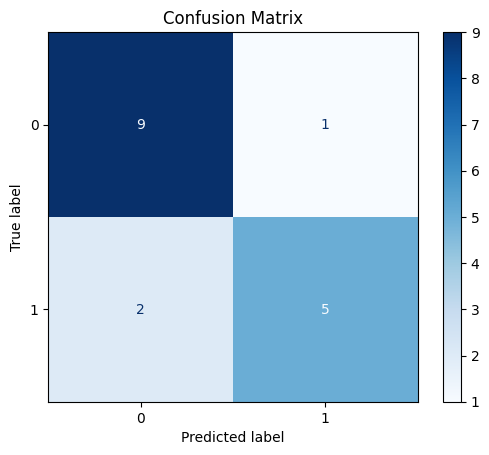

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict class labels for the test set
y_test_pred_class = (y_test_pred > 0.43).astype(int)  # Convert probabilities to binary classes

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred_class)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # Specify class labels manually
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


#metrics(skip if you use aggreagted matrix)

In [ ]:
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix

# Assuming you have X_test, y_test, and model predictions
y_true_all = y_test  # Use true labels from the test set
y_pred_all = (y_test_pred > 0.5).astype(int)  # Predicted labels with the threshold

# Store bootstrap results
n_bootstraps = 1000  # Number of bootstrap samples
rng = np.random.default_rng(42)  # Set random state for reproducibility

sensitivity_scores = []
specificity_scores = []
accuracy_scores = []
f1_scores = []

# Bootstrap resampling
for _ in range(n_bootstraps):
    # Resample indices with replacement
    indices = rng.choice(len(y_true_all), size=len(y_true_all), replace=True)
    y_true_bootstrap = np.array(y_true_all)[indices]
    y_pred_bootstrap = np.array(y_pred_all)[indices]

    # Confusion matrix
    cm = confusion_matrix(y_true_bootstrap, y_pred_bootstrap)
    tn, fp, fn, tp = cm.ravel()

    # Metrics
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    accuracy = accuracy_score(y_true_bootstrap, y_pred_bootstrap)
    f1 = f1_score(y_true_bootstrap, y_pred_bootstrap)

    # Store metrics
    sensitivity_scores.append(sensitivity)
    specificity_scores.append(specificity)
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

# Compute 95% confidence intervals
def compute_ci(scores):
    lower = np.percentile(scores, 2.5)
    upper = np.percentile(scores, 97.5)
    return lower, upper

sensitivity_ci = compute_ci(sensitivity_scores)
specificity_ci = compute_ci(specificity_scores)
accuracy_ci = compute_ci(accuracy_scores)
f1_ci = compute_ci(f1_scores)

# Print results
print(f"Sensitivity: {np.mean(sensitivity_scores):.3f} (95% CI: {sensitivity_ci[0]:.3f}, {sensitivity_ci[1]:.3f})")
print(f"Specificity: {np.mean(specificity_scores):.3f} (95% CI: {specificity_ci[0]:.3f}, {specificity_ci[1]:.3f})")
print(f"Accuracy: {np.mean(accuracy_scores):.3f} (95% CI: {accuracy_ci[0]:.3f}, {accuracy_ci[1]:.3f})")
print(f"F1 Score: {np.mean(f1_scores):.3f} (95% CI: {f1_ci[0]:.3f}, {f1_ci[1]:.3f})")


Sensitivity: 0.837 (95% CI: 0.444, 1.000)
Specificity: 0.857 (95% CI: 0.500, 1.000)
Accuracy: 0.849 (95% CI: 0.615, 1.000)
F1 Score: 0.824 (95% CI: 0.500, 1.000)


#SHAP value

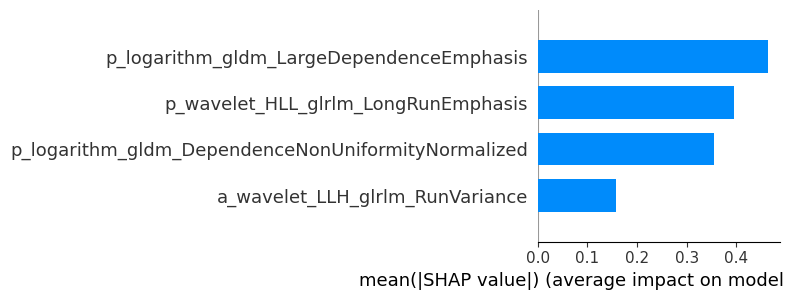

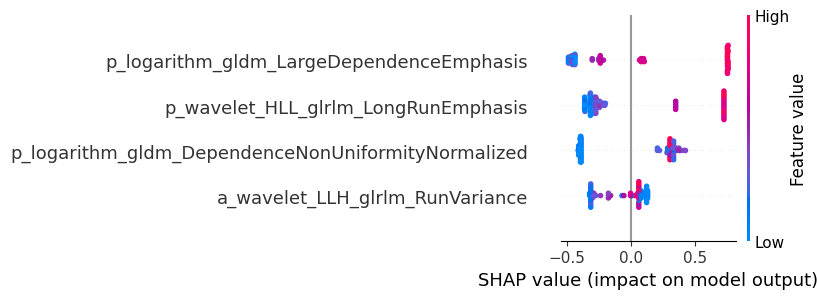

In [ ]:
import shap
import xgboost as xgb
import matplotlib.pyplot as plt

# Load XGBoost model (if not already loaded)
# Assuming `model` is your trained XGBoost model

# Prepare the data
dtrain = xgb.DMatrix(X)  # Replace `X` with your dataset used for training

# Initialize SHAP explainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values
shap_values = explainer.shap_values(dtrain)

# Summary plot for feature importance
shap.summary_plot(shap_values, X, plot_type="bar")  # Bar plot of feature importance
# Beeswarm plot for detailed SHAP values
shap.summary_plot(shap_values, X)
# Force plot for a single prediction
shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :])

